# Обработка данных с датчика

Необходимо автоматически выявлять и заполнять следующие аномалии в данных
- пропуски
- выбросы 

## Первичный анализ данных за год

### Загрузка и преобразование данных

In [174]:
import pandas as pd
import numpy as np
import ast
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

sns.set_theme()

In [87]:
puid_df = pd.read_csv('samples/p9445_2024.csv')

In [88]:
puid_df['keys'] = puid_df['keys'].apply(ast.literal_eval)
puid_df['values'] = puid_df['values'].apply(ast.literal_eval)
puid_df['meta'] = puid_df['meta'].apply(ast.literal_eval)

In [89]:
puid_df[:5]

,ts,__insert_ts,keys,values,meta,anomaly
0,2024-05-10 05:20:00,2024-05-13 05:21:06,"[[volume, c1, c2, c3, c4, c5, c6, c7, speed, o...","[[30, 9, 14, 3, 1, 2, 1, null, 78.53125, 3.847...","[{""direction"":1,""lane"":1}, {""direction"":1,""lan...",[]
1,2024-05-10 05:25:00,2024-05-13 05:21:06,"[[volume, c1, c2, c3, c4, c5, c6, c7, speed, o...","[[30, 14, 14, 2, 0, 0, 0, null, 80.55469, 3.10...","[{""direction"":1,""lane"":1}, {""direction"":1,""lan...",[]
2,2024-05-10 05:30:00,2024-05-13 05:21:06,"[[volume, c1, c2, c3, c4, c5, c6, c7, speed, o...","[[44, 28, 15, 0, 0, 1, 0, null, 78.80859, 4.62...","[{""direction"":1,""lane"":1}, {""direction"":1,""lan...",[]
3,2024-05-10 05:35:00,2024-05-13 05:21:06,"[[volume, c1, c2, c3, c4, c5, c6, c7, speed, o...","[[40, 26, 11, 1, 0, 2, 0, null, 75.41797, 4.60...","[{""direction"":1,""lane"":1}, {""direction"":1,""lan...",[]
4,2024-05-10 05:40:00,2024-05-13 05:21:06,"[[volume, c1, c2, c3, c4, c5, c6, c7, speed, o...","[[36, 18, 14, 1, 0, 2, 1, null, 86.62891, 4.08...","[{""direction"":1,""lane"":1}, {""direction"":1,""lan...",[]


### Парсинг столбцов

- meta - список источников данных. От каждого источника поступает набор данных перечисленных в keys 
- keys - наборы ключей для каждого источника. К примеру если meta длины 4 то keys тоже длины 4 и каждый элемент keys - список, содержащий наблюдаемые параметры
- values - значения параметров. Размерность совпадает с keys

Извлечение метаданных. Они константные для датчика

In [90]:
meta = list(map(json.loads, puid_df['meta'][0]))
meta

[{'direction': 1, 'lane': 1},
 {'direction': 1, 'lane': 2},
 {'direction': 0, 'lane': 1},
 {'direction': 0, 'lane': 2}]

In [91]:
titles = list(map(lambda x: f'{"Прямое" if  x["direction"] == 1 else "Обратное"}, полоса {x["lane"]}', meta))
titles

['Прямое, полоса 1',
 'Прямое, полоса 2',
 'Обратное, полоса 1',
 'Обратное, полоса 2']

Маппинг значений по ключам. Для начала будем использовать только основные параметры
- volume
- speed 
- occupancy

In [92]:
keys = puid_df['keys'][0][0]
general_key_indices = [keys.index('volume'), keys.index('speed'), keys.index('occupancy')]
general_key_indices

[0, 8, 9]

In [93]:
# получение значений из первого источника в meta
def get_processor(source_index):
    def process_keys(row):
        return pd.Series(map(lambda i: pd.to_numeric(row['values'][source_index][i], errors='coerce'), general_key_indices), index=map(lambda i: keys[i], general_key_indices))
    
    return process_keys

params_df =  puid_df.apply(get_processor(0), axis=1)
puid_source_0 = pd.concat([puid_df['ts'], params_df], axis=1)

In [94]:
puid_source_0['ts'] = pd.to_datetime(puid_source_0['ts'])
puid_source_0.set_index('ts', inplace=True)
puid_source_0.index = pd.to_datetime(puid_source_0.index)

In [95]:
puid_source_0.dtypes

volume       float64
speed        float64
occupancy    float64
dtype: object

In [96]:
puid_source_0.index.dtype

dtype('<M8[ns]')

<Axes: xlabel='ts'>

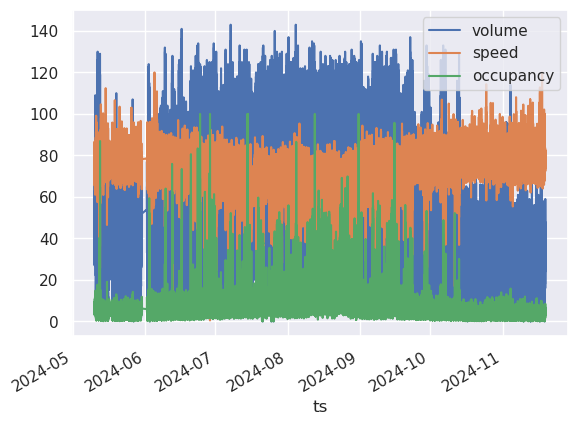

In [97]:
puid_source_0.plot()

In [98]:
puid_source_0[:10]

,volume,speed,occupancy
ts,,,
2024-05-10 05:20:00,30.0,78.531250,3.847656
2024-05-10 05:25:00,30.0,80.554690,3.105469
2024-05-10 05:30:00,44.0,78.808590,4.628906
2024-05-10 05:35:00,40.0,75.417970,4.609375
2024-05-10 05:40:00,36.0,86.628910,4.082031
2024-05-10 05:45:00,38.0,76.582030,4.523438
2024-05-10 05:50:00,44.0,80.183590,4.558594
2024-05-10 05:55:00,35.0,83.546875,3.691406
2024-05-10 06:00:00,30.0,79.605470,3.121094


In [99]:
puid_source_0.describe()

,volume,speed,occupancy
count,62749.000000,62749.000000,62749.000000
mean,55.142520,71.377247,8.536781
std,32.361313,12.441948,8.634890
min,0.000000,0.484375,0.000000
25%,28.000000,69.050780,3.484375
50%,51.000000,73.664060,6.410156
75%,82.000000,77.882810,10.351562
max,143.000000,120.000000,100.000000


## Поиск пропущенных значений 

Данные собираются с интервалом в 5 минут. Необходимо найти timestamps в которые отсутствуют данные

Проверка индекса на дубликаты

In [100]:
puid_source_0.index.duplicated().sum()

7938

При наличии продублированных записей нужно определить какие данные оставлять 

In [101]:
puid_source_0[puid_source_0.index.duplicated(keep=False)]

,volume,speed,occupancy
ts,,,
2024-05-21 06:55:00,31.0,75.984375,3.332031
2024-05-21 06:55:00,31.0,75.984375,3.332031
2024-05-21 07:00:00,33.0,81.144530,3.371094
2024-05-21 07:00:00,33.0,81.144530,3.371094
2024-05-21 07:05:00,30.0,76.023440,4.339844
...,...,...,...
2024-11-14 09:05:00,28.0,75.632810,4.121094
2024-11-14 09:10:00,37.0,71.847660,5.761719
2024-11-14 09:10:00,37.0,71.847660,5.761719


Проверка на различные дубликаты

In [102]:
duplicates = puid_source_0.groupby(puid_source_0.index).nunique()
duplicates[duplicates.gt(1).any(axis=1)]

,volume,speed,occupancy
ts,,,


Так как дубликаты повторяются можно удалить их. Иначе можно усреднить или оставить только первое/последнее значение

In [103]:
puid_source_0 = puid_source_0[~puid_source_0.index.duplicated(keep='first')]

In [104]:
range2024 = pd.date_range('2024-01-01 00:00', '2024-12-31 23:55', freq='5Min')
puid_source_0_na = puid_source_0.reindex(range2024)
puid_source_0_na.describe()

,volume,speed,occupancy
count,54811.000000,54811.000000,54811.000000
mean,55.139187,71.447210,8.477453
std,32.201708,12.253072,8.530749
min,0.000000,0.484375,0.000000
25%,28.000000,69.089840,3.492188
50%,51.000000,73.632810,6.433594
75%,81.000000,77.832030,10.289062
max,143.000000,120.000000,100.000000


<Axes: >

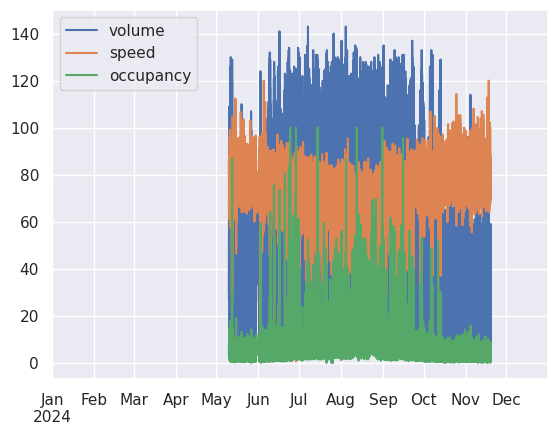

In [105]:
puid_source_0_na.plot()

In [106]:
# количество пятиминутных интервалов в году
rows_count = pd.Timestamp(2024, 12, 31).dayofyear * (24 * 60 / 5)
rows_count

105408.0

In [107]:
assert len(puid_source_0_na.index) == rows_count

Данные нормализованы по времени. Теперь необходимо корректно заполнить каждый тип пропущенных значений

## Заполнение пропусков

Заполнять пропуски можно 
- линейно
- скользящим окном 
- средними за период (день, неделя)
- средним за все ts в году (к примеру усредняем все значения каждого дня в 05:55:00)

Виды пропусков
- в определенное время дня
- целыми интервалами

Имеет смысл заполнять пропуски если их не большинство и они не регулярны весь период

### Определение характера пропущенных данных

In [108]:
puid_source_0_na = puid_source_0_na.reset_index()
puid_source_0_na['is_nan'] = puid_source_0_na['volume'].isna().astype(int)  
puid_source_0_na['group'] = (puid_source_0_na['is_nan'].diff() == 1).cumsum()  
nan_intervals = puid_source_0_na[puid_source_0_na['is_nan'] == 1].groupby('group').agg(start=('index', 'first'), end=('index', 'last'))

In [109]:
nan_intervals['duration'] = nan_intervals['end'] - nan_intervals['start'] 

In [110]:
nan_intervals

,start,end,duration
group,,,
0,2024-01-01 00:00:00,2024-05-10 05:15:00,130 days 05:15:00
1,2024-05-16 19:15:00,2024-05-17 11:35:00,0 days 16:20:00
2,2024-05-18 23:20:00,2024-05-18 23:20:00,0 days 00:00:00
3,2024-05-30 14:05:00,2024-06-01 16:25:00,2 days 02:20:00
4,2024-06-17 23:25:00,2024-06-17 23:25:00,0 days 00:00:00
5,2024-07-04 13:05:00,2024-07-04 13:05:00,0 days 00:00:00
6,2024-07-16 22:05:00,2024-07-16 22:05:00,0 days 00:00:00
7,2024-07-17 22:05:00,2024-07-17 22:05:00,0 days 00:00:00
8,2024-07-31 22:10:00,2024-07-31 22:10:00,0 days 00:00:00


In [ ]:
puid_source_0_na.drop(['is_nan', 'group'], axis=1, inplace=True)
puid_source_0_na.set_index('index', inplace=True)

In [136]:
def get_interval(index):
    return nan_intervals.loc[index].start, nan_intervals.loc[index].end

def plot_missing(df: pd.DataFrame, nan_df: pd.DataFrame):
    num_cols = 3
    fig, axs = plt.subplots(ncols=num_cols, nrows=nan_df.shape[0] // num_cols + 1, figsize=(25, 25))
    for (interval_data, i) in zip(nan_df.itertuples(index=False), range(nan_df.shape[0])):
        delta = interval_data.duration if interval_data.duration != pd.Timedelta(0) else pd.Timedelta(hours=1)
        df.loc[interval_data.start - delta:interval_data.end + delta].plot(ax=axs[i // num_cols, i % num_cols])

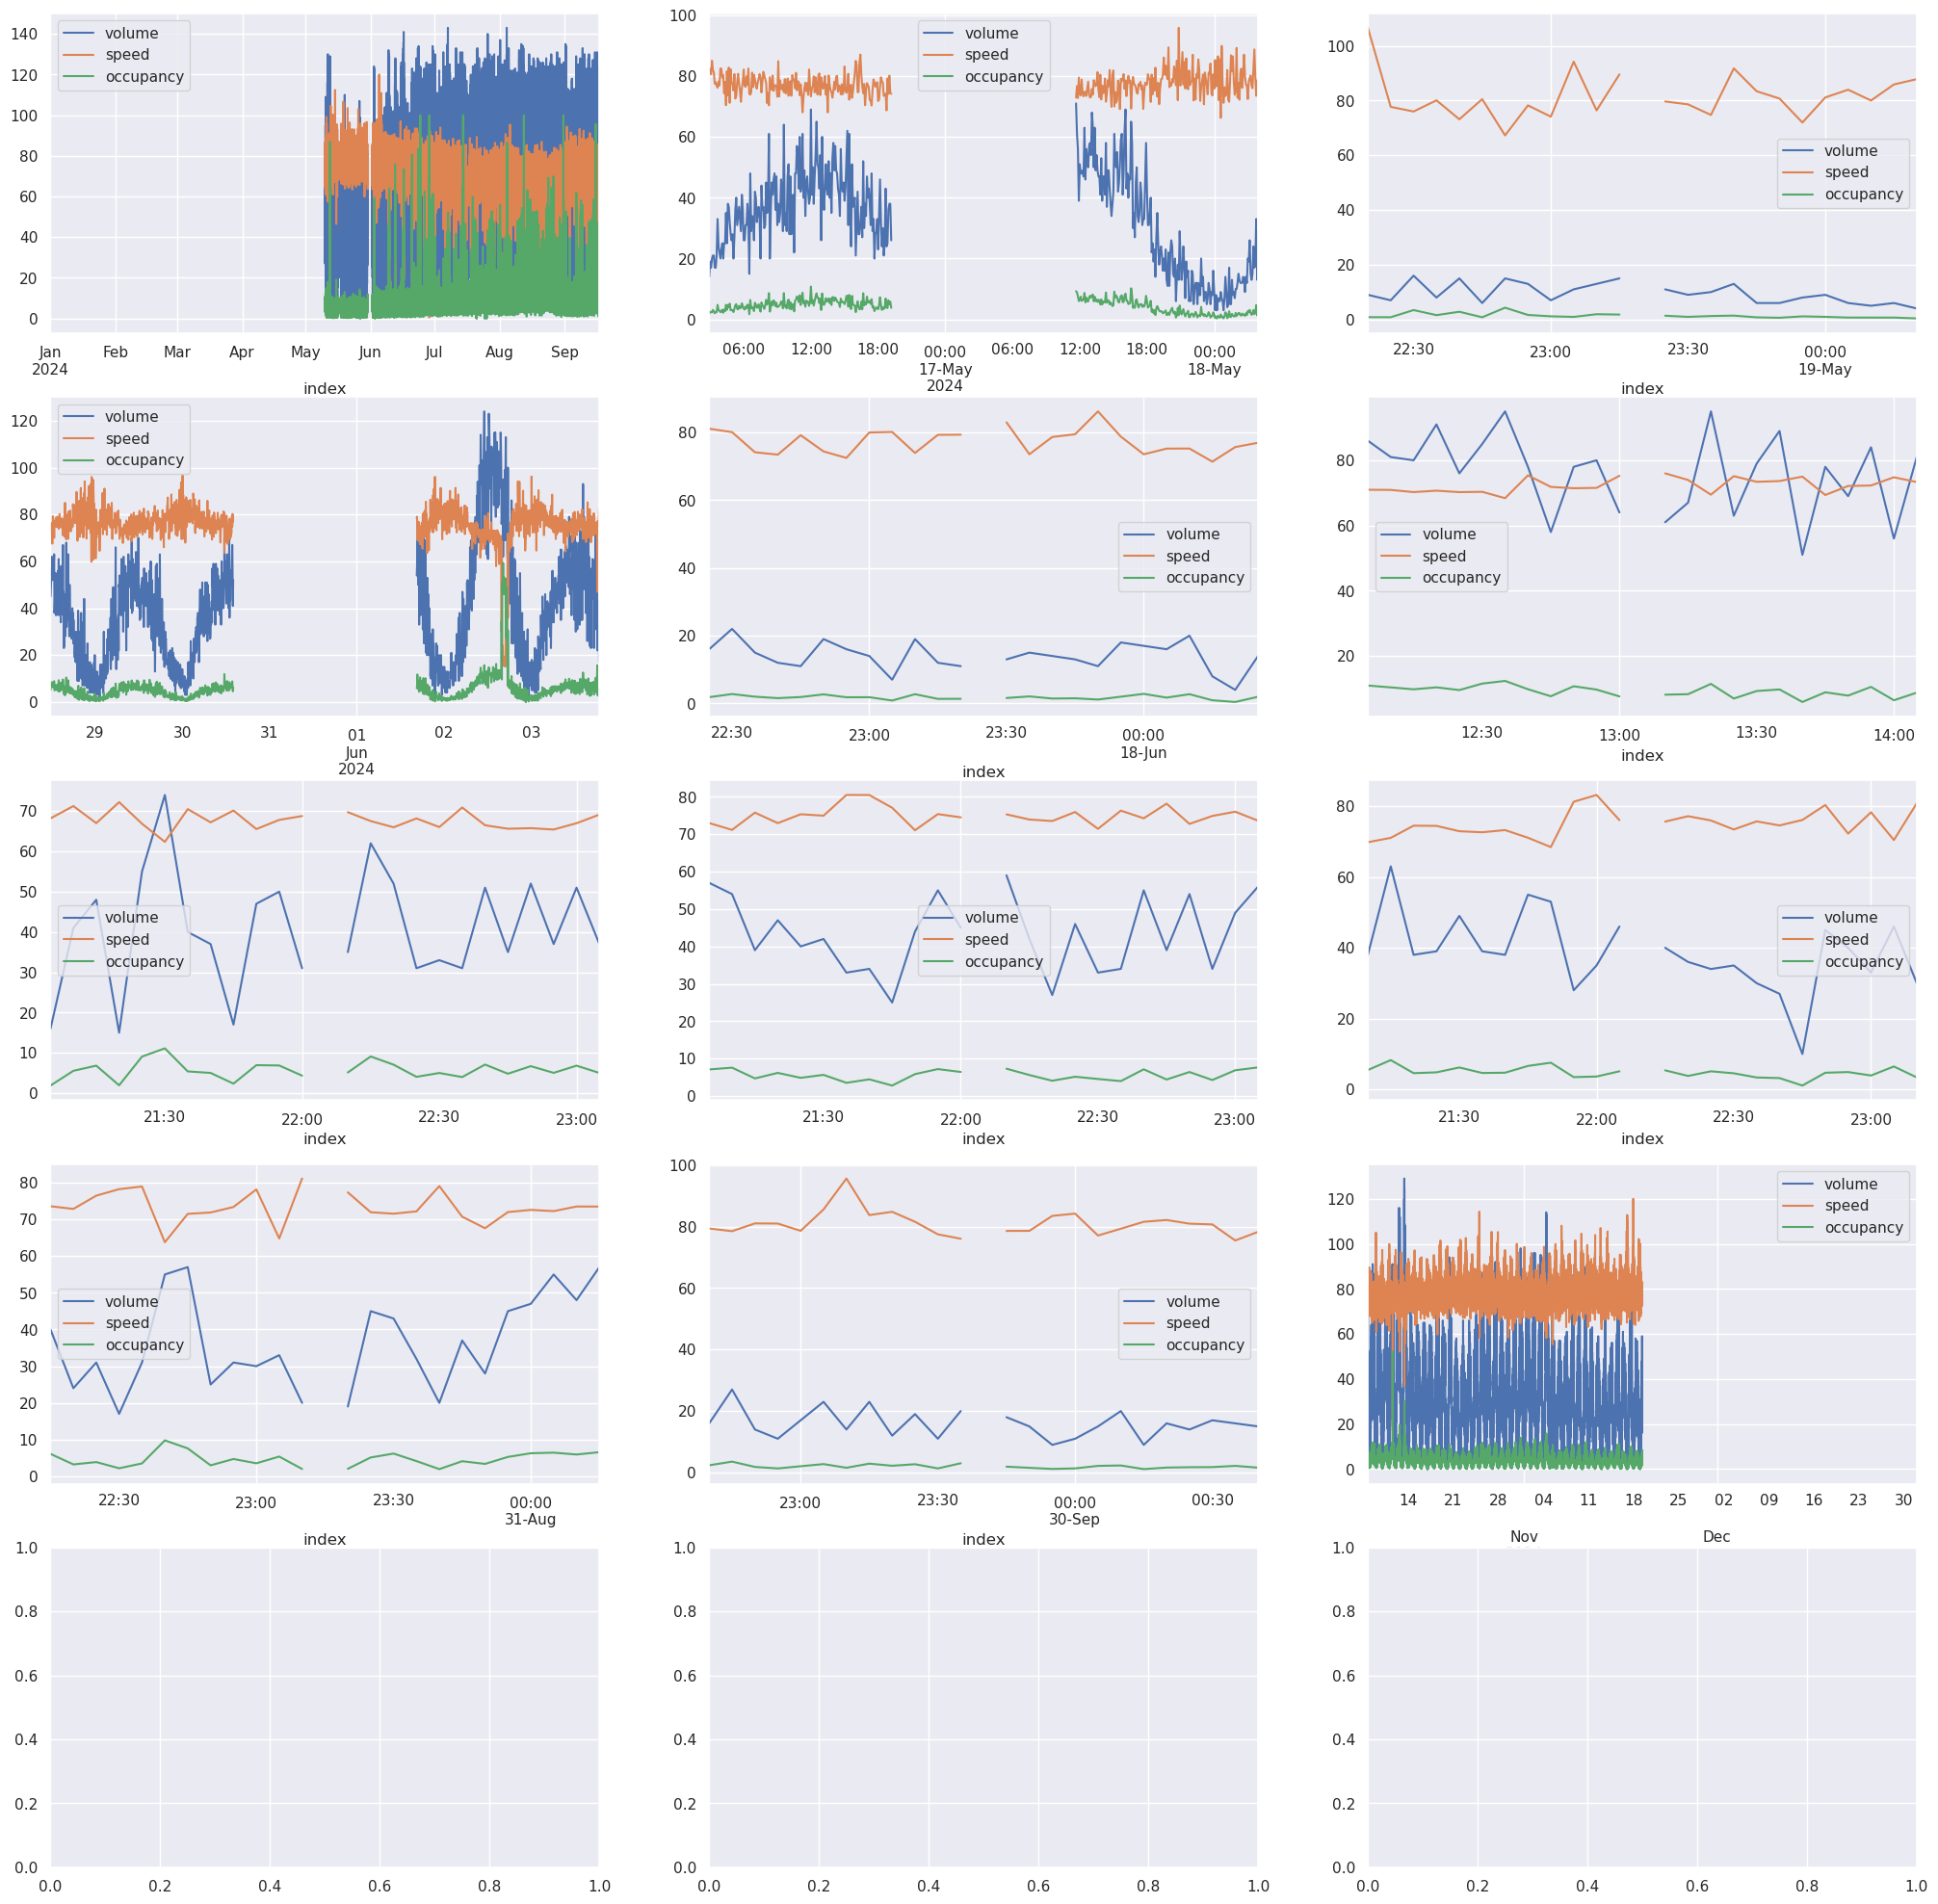

In [137]:
plot_missing(puid_source_0_na, nan_intervals)

#### 1. Пустой интервал длиной более месяца

Теряются данные о сезонности, поэтому заполнять средним или интерполяцией нет смысла. Данные стоит исключить из рассмотрения 

#### 2. Интервал внутри месяца

Заполнить средними значениями за известные дни года. Для учета сезонности можно сгладить значения используя порядок роста функции справа и слева а также максимумы и минимумы периода

<Axes: xlabel='index'>

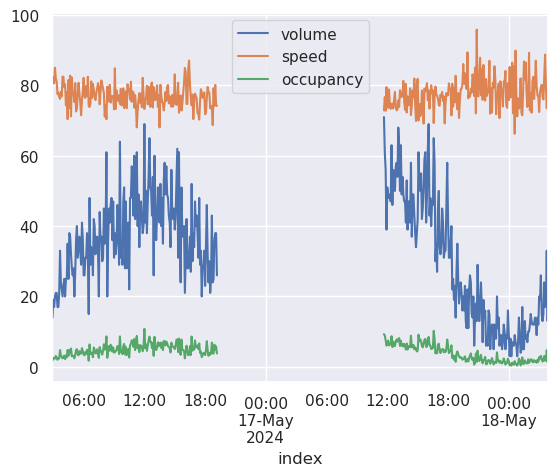

In [199]:
s1, e1, dur1 = nan_intervals.loc[1].start, nan_intervals.loc[1].end, nan_intervals.loc[1].duration
puid_source_0_na.loc[s1 - dur1:e1 + dur1].plot()

##### 2.1 Заполнение интерполяцией

/tmp/ipykernel_48621/3595931768.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice_puid['Trend_Polyfit'] = trend_func(range(len(slice_puid)))


<Axes: xlabel='index'>

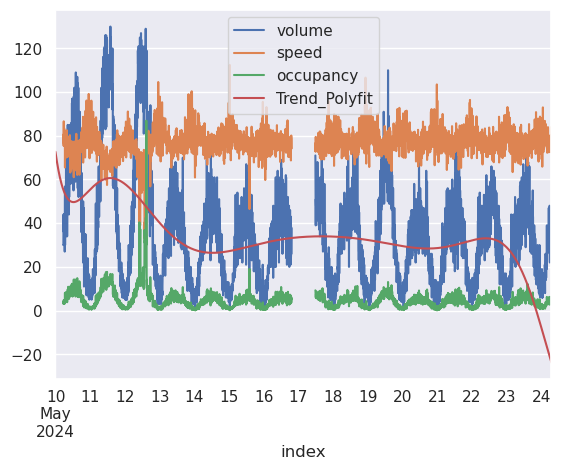

In [201]:
# puid_source_0_na.loc[s1 - dur1:e1 + dur1].interpolate(method='spline', order=2).plot()
dur = dur1 * 10
slice_puid = puid_source_0_na.loc[s1 - dur:e1 + dur]
known = slice_puid.dropna().reset_index()
x = known.index.values  # Индексы
y = known['volume'].values  # Известные значения
poly = np.polyfit(x, y, deg=10)
trend_func = np.poly1d(poly)

# Заполняем пропущенные значения трендом
slice_puid['Trend_Polyfit'] = trend_func(range(len(slice_puid)))

slice_puid.plot()

Интерполяция сплайном плохо прогнозирует пустые значения, так как не учитываются суточные колебания

In [208]:
slice_puid.drop('Trend_Polyfit', axis=1, inplace=True)

/tmp/ipykernel_48621/2891736857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice_puid.drop('Trend_Polyfit', axis=1, inplace=True)


##### 2.2 Интерполяция SARIMA

In [213]:
dur = dur1 * 10
slice_puid = puid_source_0_na.loc[s1 - dur:e1 + dur]

In [215]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(slice_puid['volume'], order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False)
result = model.fit()

slice_puid['SARIMA_Filled'] = slice_puid['volume'].copy()
slice_puid.loc[slice_puid['volume'].isna(), 'SARIMA_Filled'] = result.predict()[slice_puid['volume'].isna()]


/home/nick/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/home/nick/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52369D+00    |proj g|=  7.09661D-02

At iterate    5    f=  3.40255D+00    |proj g|=  6.62586D-02

At iterate   10    f=  3.36783D+00    |proj g|=  4.69262D-03

At iterate   15    f=  3.36554D+00    |proj g|=  5.02876D-03

At iterate   20    f=  3.36527D+00    |proj g|=  4.74181D-04

At iterate   25    f=  3.36523D+00    |proj g|=  6.01484D-04

At iterate   30    f=  3.36522D+00    |proj g|=  4.93846D-04

At iterate   35    f=  3.36522D+00    |proj g|=  5.50926D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/tmp/ipykernel_48621/758454466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice_puid['SARIMA_Filled'] = slice_puid['volume'].copy()


<Axes: xlabel='index'>

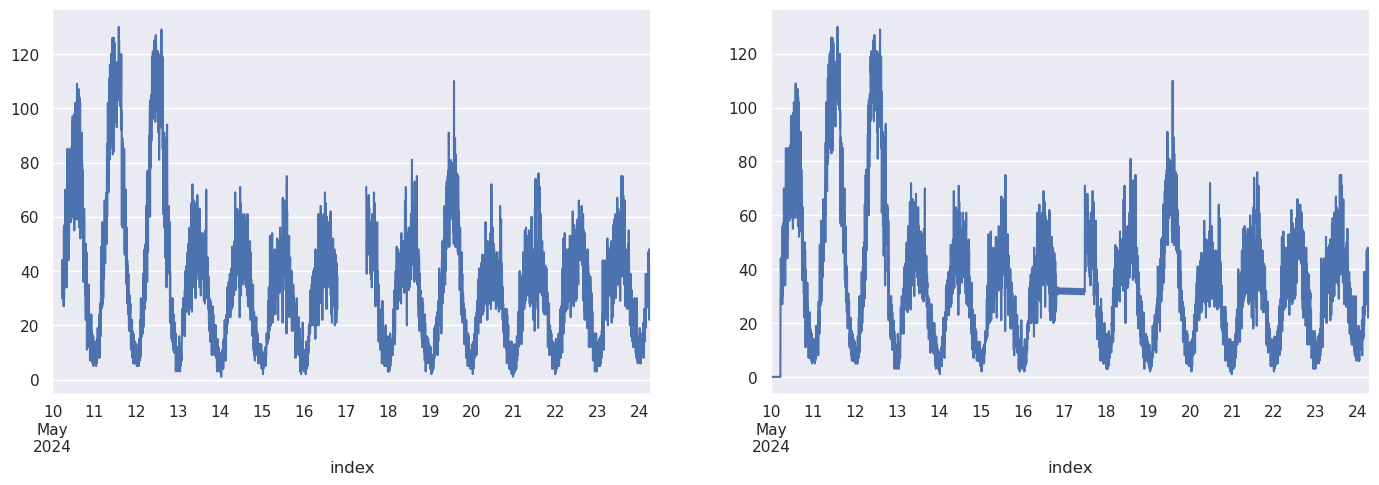

In [225]:
fig, ax = plt.subplots(ncols=2, figsize=(17, 5))

slice_puid['volume'].plot(ax=ax[0])
slice_puid['SARIMA_Filled'].plot(ax=ax[1])

<Axes: xlabel='index'>

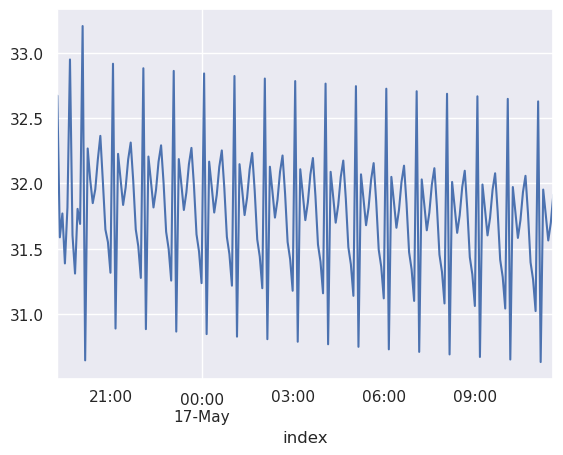

In [236]:
slice_puid[s1:e1]['SARIMA_Filled'].plot()

Оставить в обучении данные за сутки

/tmp/ipykernel_48621/3307160676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice_puid2.drop('SARIMA_Filled', axis=1, inplace=True)


<Axes: xlabel='index'>

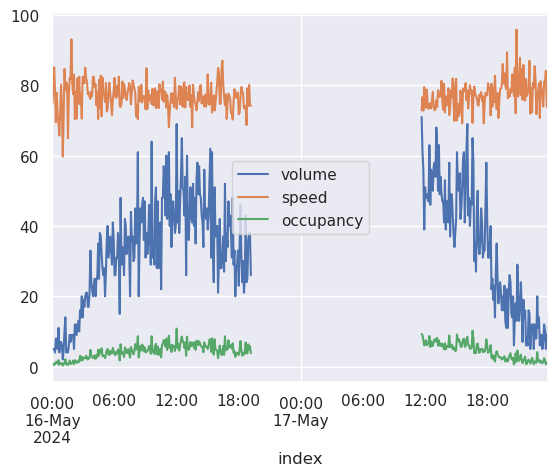

In [240]:
slice_puid2 = slice_puid[s1.normalize():e1.replace(hour=23,minute=55)]
slice_puid2.drop('SARIMA_Filled', axis=1, inplace=True)
slice_puid2.plot()

In [241]:
model = SARIMAX(slice_puid2['volume'], order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False)
result = model.fit()

slice_puid2['SARIMA_Filled'] = slice_puid2['volume'].copy()
slice_puid2.loc[slice_puid2['volume'].isna(), 'SARIMA_Filled'] = result.predict()[slice_puid2['volume'].isna()]

/home/nick/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/home/nick/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30024D+00    |proj g|=  7.62420D-02

At iterate    5    f=  2.23709D+00    |proj g|=  4.99153D-02

At iterate   10    f=  2.21530D+00    |proj g|=  3.15989D-02

At iterate   15    f=  2.19194D+00    |proj g|=  1.73613D-01

At iterate   20    f=  2.19159D+00    |proj g|=  4.69524D-03

At iterate   25    f=  2.19151D+00    |proj g|=  1.26511D-02

At iterate   30    f=  2.19151D+00    |proj g|=  1.36978D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/tmp/ipykernel_48621/3245805708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice_puid2['SARIMA_Filled'] = slice_puid2['volume'].copy()


<Axes: xlabel='index'>

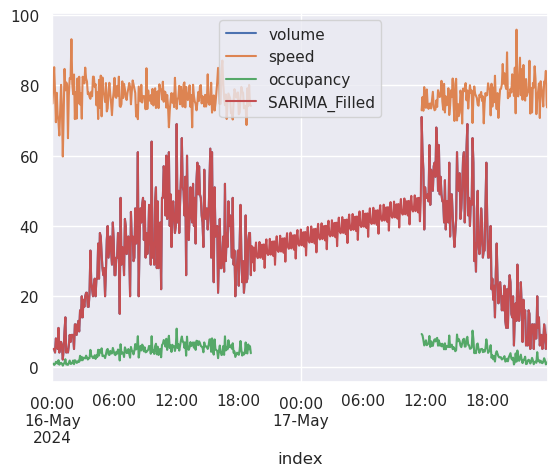

In [242]:
slice_puid2.plot()

##### 2.3 Заполнение средним 

In [244]:
dur = dur1 * 10
slice_puid = puid_source_0_na.loc[s1 - dur:e1 + dur]

In [263]:
puid_source_0.reset_index()

,ts,volume,speed,occupancy
0,2024-05-10 05:20:00,30.0,78.53125,3.847656
1,2024-05-10 05:25:00,30.0,80.55469,3.105469
2,2024-05-10 05:30:00,44.0,78.80859,4.628906
3,2024-05-10 05:35:00,40.0,75.41797,4.609375
4,2024-05-10 05:40:00,36.0,86.62891,4.082031
...,...,...,...,...
54806,2024-11-19 08:00:00,34.0,74.71484,4.644531
54807,2024-11-19 08:05:00,34.0,80.55469,4.707031
54808,2024-11-19 08:10:00,35.0,77.02344,3.992188
54809,2024-11-19 08:15:00,30.0,79.80078,3.941406


In [268]:
puid_source_0['timestamps'] = puid_source_0.reset_index()['ts'].dt.time
puid_source_0.groupby('ts')['volume'].mean()

ts
2024-05-10 05:20:00    30.0
2024-05-10 05:25:00    30.0
2024-05-10 05:30:00    44.0
2024-05-10 05:35:00    40.0
2024-05-10 05:40:00    36.0
                       ... 
2024-11-19 08:00:00    34.0
2024-11-19 08:05:00    34.0
2024-11-19 08:10:00    35.0
2024-11-19 08:15:00    30.0
2024-11-19 08:20:00    35.0
Name: volume, Length: 54811, dtype: float64

#### 3. Повторяющиеся интервалы за весь год (к примеру нет данных о каждом часе)

Если в рамках интервала не меняется монотонность (к примеру известно что в пропущенном часе присутвует пиковое значение) можно восстановить интерполяцией. Иначе данные стоит исключить из рассмотрения

#### 4. Короткие единичные пропуски (не более пары часов)

Заполняется интерполяцией если нет пиков, иначе средним 

<Axes: xlabel='index'>

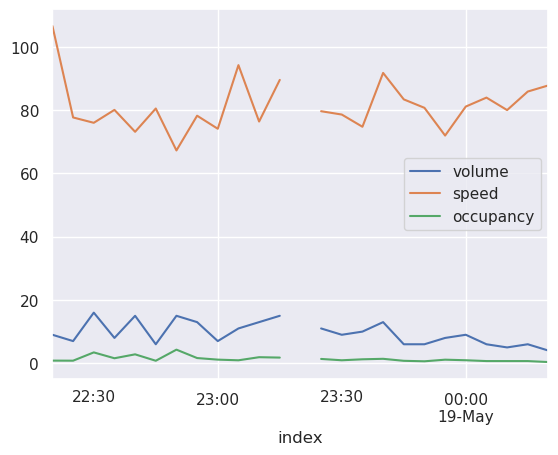

In [194]:
s1, e1, dur1 = nan_intervals.loc[2].start, nan_intervals.loc[2].end, pd.Timedelta('1h')
slice_puid = puid_source_0_na.loc[s1 - dur1:e1 + dur1]

slice_puid.plot()

<Axes: xlabel='index'>

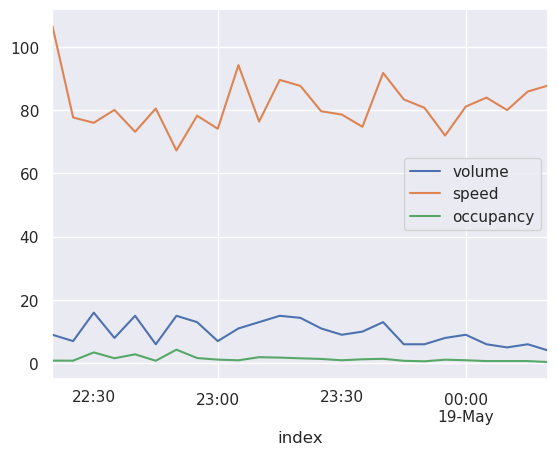

In [196]:
slice_puid.interpolate(method='spline', order=2).plot()

## Поиск аномалий

- значение в несколько раз выше/ниже обычного (скачки и спады)
- вторая производная
- отличия между направлениями (в несколько раз)

реальные аномалии:
- изменение геометрии дороги
- сезонность

Можно осуществлять несколькими методами. Удаление аномалий и повышение чистоты данных будет напрямую влиять на качество обучения

1. Экспертная оценка

- обратное и прямое направление отличаются в несколько раз (сюда же относится отсутствие трафика по одному направлению когда другое направление представлено)
- резко возрастает показатель интенсивности
- интенсивность изменяется несколько раз в сутки

2. Микросервис 

через аномалии определялась корректность работы пуид

но для аналитических задач нужен другой подход

Для каждого временного промежутка выбрать метод восстановления

1. достроить пропуски
2. нормализация данных (удаление аномалий)
- учет часовых значений